<a href="https://colab.research.google.com/github/kshitijzutshi/Customer-Churn-Prediction-2020/blob/main/Customer_Churn_Prediction_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Abstract

Customer churn, also known as attrition, occurs when a customer stops doing business with a company. Understanding and detecting churn is the first step to retaining these customers and improving the company’s offerings.

The task is to perform a churn analysis on a [Kaggle competition - Customer Churn Prediction 2020](https://www.kaggle.com/c/customer-churn-prediction-2020/overview) to predict whether a customer will change telco provider.

In [383]:
!pip install fitter

In [384]:
import pandas as pd
import seaborn as sns
from numpy import unique
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pandas.plotting import scatter_matrix
# Building a model imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from fitter import Fitter, get_common_distributions, get_distributions

In [385]:
# Loading the train & test dataset

train = pd.read_csv('https://raw.githubusercontent.com/kshitijzutshi/Customer-Churn-Prediction-2020/main/dataset/train.csv')
df_train = pd.DataFrame(train)

test = pd.read_csv('https://raw.githubusercontent.com/kshitijzutshi/Customer-Churn-Prediction-2020/main/dataset/test.csv')
df_test = pd.DataFrame(test)

df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


### Dataset Description

The training dataset contains **4250 samples**. Each sample contains **19 features and 1 boolean variable "churn"** which indicates the class of the sample. 

The 19 input features and 1 target variable are:




```

state , string  ->  2-letter code of the US state of customer residence

account_length, numerical -> Number of months the customer has been with the current telco provider

area_code, string="area_code_AAA" where AAA = 3 digit area code.
    
international_plan, (yes/no) -> The customer has international plan.
    
voice_mail_plan, (yes/no) -> The customer has voice mail plan.
    
number_vmail_messages, numerical. Number of voice-mail messages.
    
total_day_minutes", numerical. Total minutes of day calls.
    
total_day_calls", numerical. Total minutes of day calls.

"total_day_charge", numerical. Total charge of day calls.

"total_eve_minutes", numerical. Total minutes of evening calls.

"total_eve_calls", numerical. Total number of evening calls.

"total_eve_charge", numerical. Total charge of evening calls.

"total_night_minutes", numerical. Total minutes of night calls.

"total_night_calls", numerical. Total number of night calls.

"total_night_charge", numerical. Total charge of night calls.

"total_intl_minutes", numerical. Total minutes of international calls.

"total_intl_calls", numerical. Total number of international calls.

"total_intl_charge", numerical. Total charge of international calls

"number_customer_service_calls", numerical. Number of calls to customer service

"churn", (yes/no). Customer churn - target variable.

```


    







In [386]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

#### For State, we can make it a category and have a mapped list of state name and its assigned code.

In [387]:
df_train.state = df_train.state.astype('category')

In [388]:
dict( enumerate(df_train['state'].cat.categories ) )

{0: 'AK',
 1: 'AL',
 2: 'AR',
 3: 'AZ',
 4: 'CA',
 5: 'CO',
 6: 'CT',
 7: 'DC',
 8: 'DE',
 9: 'FL',
 10: 'GA',
 11: 'HI',
 12: 'IA',
 13: 'ID',
 14: 'IL',
 15: 'IN',
 16: 'KS',
 17: 'KY',
 18: 'LA',
 19: 'MA',
 20: 'MD',
 21: 'ME',
 22: 'MI',
 23: 'MN',
 24: 'MO',
 25: 'MS',
 26: 'MT',
 27: 'NC',
 28: 'ND',
 29: 'NE',
 30: 'NH',
 31: 'NJ',
 32: 'NM',
 33: 'NV',
 34: 'NY',
 35: 'OH',
 36: 'OK',
 37: 'OR',
 38: 'PA',
 39: 'RI',
 40: 'SC',
 41: 'SD',
 42: 'TN',
 43: 'TX',
 44: 'UT',
 45: 'VA',
 46: 'VT',
 47: 'WA',
 48: 'WI',
 49: 'WV',
 50: 'WY'}

#### To show the distribution of the independent features using **Histogram**, we need to assign codes to categorical variables in dataset.

In [389]:
df_train.state = pd.Categorical(df_train.state).codes
# df_train.area_code = pd.Categorical(df_train.area_code).codes
# df_train.area_code = df_train.area_code.map({'area_code_415':415,'area_code_408':408,'area_code_510':510})
dummy_columns = pd.get_dummies(df_train.area_code, prefix='area_code')
  # axis{0/’index’, 1/’columns’}, default 0 -> The axis to concatenate along.
df_train = pd.concat([df_train.drop(columns='area_code'), dummy_columns], axis=1)

# dummy_columns_state = pd.get_dummies(df_train.state, prefix='state')
#   # axis{0/’index’, 1/’columns’}, default 0 -> The axis to concatenate along.
# df_train = pd.concat([df_train.drop(columns='state'), dummy_columns_state], axis=1)

df_train.international_plan = pd.Categorical(df_train.international_plan).codes
df_train.voice_mail_plan = pd.Categorical(df_train.voice_mail_plan).codes
df_train.churn = pd.Categorical(df_train.churn).codes


df_test.state = pd.Categorical(df_test.state).codes
# df_test.area_code = pd.Categorical(df_test.area_code).codes
dummy_columns = pd.get_dummies(df_test.area_code, prefix='area_code')
df_test = pd.concat([df_test.drop(columns='area_code'), dummy_columns], axis=1)
df_test.international_plan = pd.Categorical(df_test.international_plan).codes
df_test.voice_mail_plan = pd.Categorical(df_test.voice_mail_plan).codes

In [390]:
df_train.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,35,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,1,0
1,31,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,1,0
2,35,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1,0,0
3,36,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,1,0
4,19,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0,0,1


In [391]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   int8   
 1   account_length                 4250 non-null   int64  
 2   international_plan             4250 non-null   int8   
 3   voice_mail_plan                4250 non-null   int8   
 4   number_vmail_messages          4250 non-null   int64  
 5   total_day_minutes              4250 non-null   float64
 6   total_day_calls                4250 non-null   int64  
 7   total_day_charge               4250 non-null   float64
 8   total_eve_minutes              4250 non-null   float64
 9   total_eve_calls                4250 non-null   int64  
 10  total_eve_charge               4250 non-null   float64
 11  total_night_minutes            4250 non-null   float64
 12  total_night_calls              4250 non-null   i

In [392]:
df_train.describe()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,26.094118,100.236235,0.093176,0.261647,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059,0.140706,0.255529,0.496000,0.248471
std,14.769049,39.698401,0.290714,0.439583,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434,0.347759,0.436210,0.500043,0.432177
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,73.000000,0.000000,0.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,100.000000,0.000000,0.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,39.000000,127.000000,0.000000,1.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000,1.000000,1.000000,0.000000
max,50.000000,243.000000,1.000000,1.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,1.000000,1.000000,1.000000


In [393]:
# Check for null values
df_train.isna().any(axis=0).any()

False

In [394]:
# Checking number of unique values in each column
df_train.nunique()

state                              51
account_length                    215
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              46
total_day_minutes                1843
total_day_calls                   120
total_day_charge                 1843
total_eve_minutes                1773
total_eve_calls                   123
total_eve_charge                 1572
total_night_minutes              1757
total_night_calls                 128
total_night_charge                992
total_intl_minutes                168
total_intl_calls                   21
total_intl_charge                 168
number_customer_service_calls      10
churn                               2
area_code_area_code_408             2
area_code_area_code_415             2
area_code_area_code_510             2
dtype: int64

In [395]:
df_train.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
0,35,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,0,1,0
1,31,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0,1,0
2,35,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,1,0,0
3,36,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0,1,0
4,19,121,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0,0,0,1


Get a histogram distribution of each feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f730b28d9d0>,
      dtype=object)

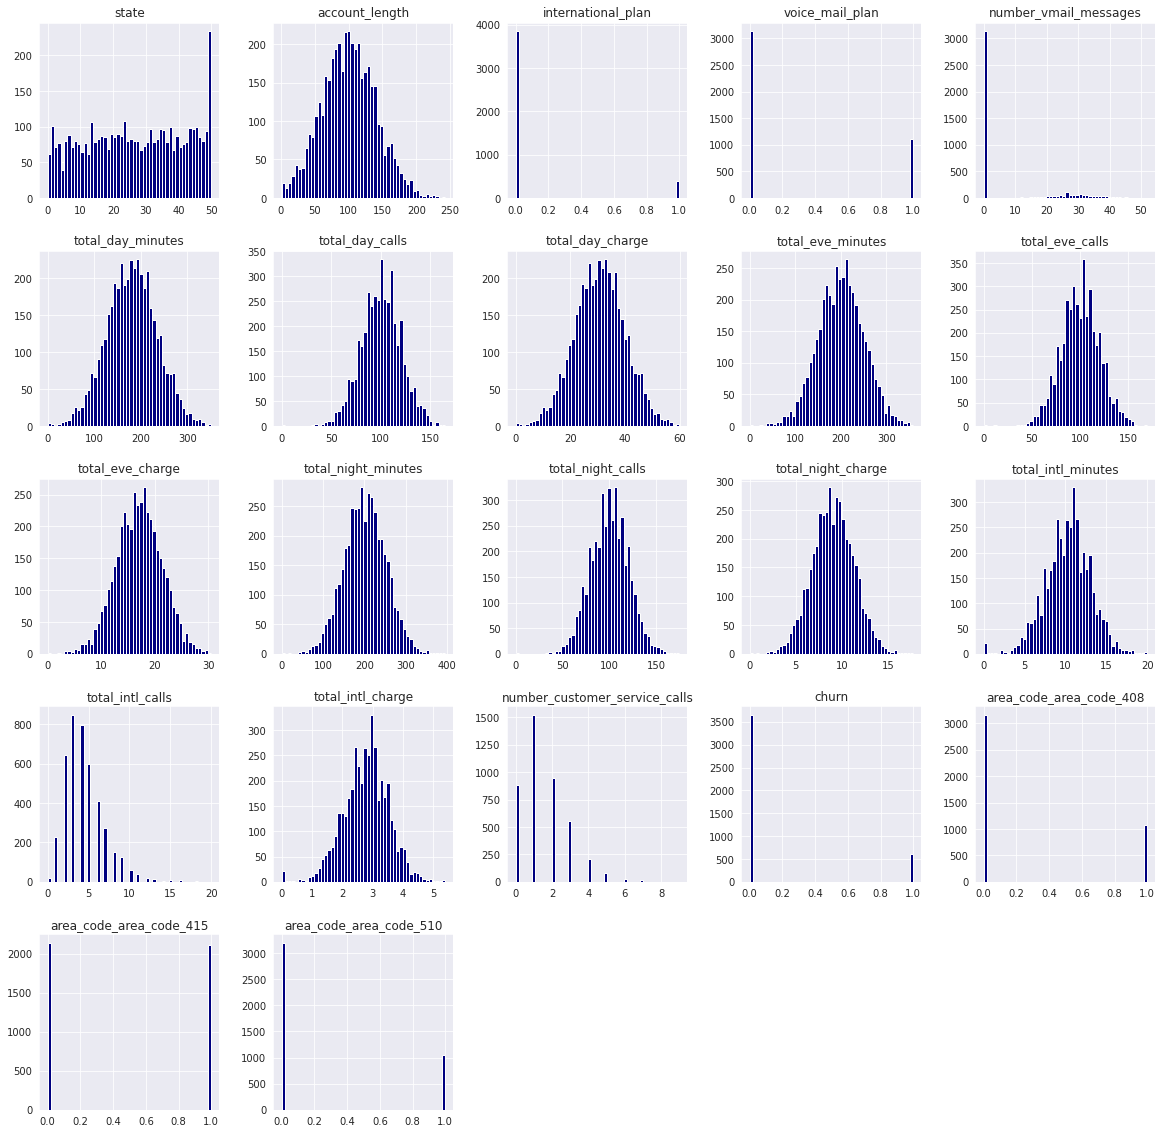

In [396]:
sns.set_style('dark')
df_train.hist(bins=50,figsize=(20,20),color='navy')

Getting best fitting distribution for the Input features:

For the **account length feature**, the best fitting ditribution is **Normal Distribution** based on least sum of square error.

,sumsquare_error,aic,bic,kl_div
norm,0.000184,1263.803790,-72034.848539,inf
gamma,0.000185,1252.351531,-72022.770002,inf
beta,0.000186,1262.911986,-71990.829704,inf
burr,0.000197,1241.322073,-71726.130831,inf
lognorm,0.008588,1477.875788,-55701.353144,inf


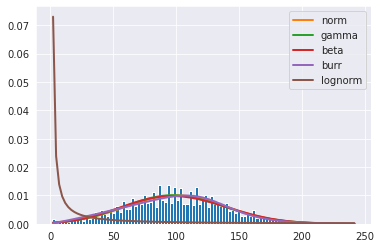

In [397]:
f = Fitter(df_train.account_length,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
gamma,0.000020,1341.439176,-81492.621071,inf
norm,0.000020,1339.277201,-81498.919969,inf
beta,0.000020,1345.821552,-81462.496608,inf
burr,0.000096,1415.003837,-74802.467771,inf
lognorm,0.004135,1585.306168,-58806.932463,inf


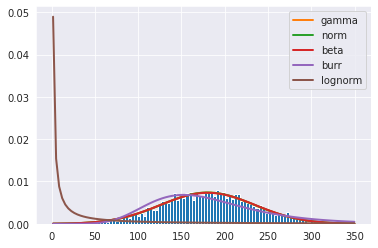

In [398]:
# total day minutes is also normal distribution
f = Fitter(df_train.total_day_minutes,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
beta,0.000792,1404.809527,-65823.975032,inf
norm,0.000792,1438.150154,-65837.919803,inf
lognorm,0.000794,1456.792319,-65818.114521,inf
gamma,0.000799,1467.606969,-65793.156413,inf
burr,0.001350,2354.461967,-63556.398837,inf


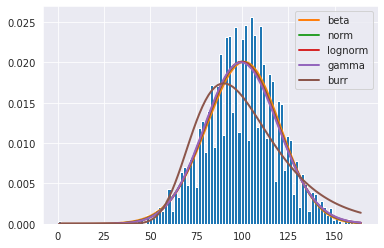

In [399]:
# total day calls is a normal distribution
f = Fitter(df_train.total_day_calls,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
gamma,0.000672,987.079447,-66532.705802,inf
norm,0.000672,984.941774,-66538.903169,inf
beta,0.000675,991.482038,-66503.121575,inf
lognorm,0.000677,987.902485,-66495.555705,inf
burr,0.001031,966.718620,-64701.159897,inf


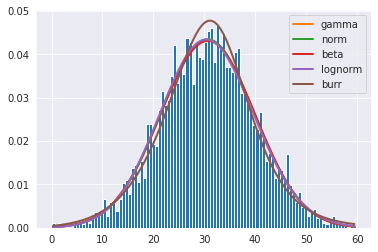

In [400]:
# total day charge is also a normal distribution
f = Fitter(df_train.total_day_charge,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.000020,1413.966908,-81500.657288,inf
gamma,0.000020,1419.763744,-81488.867246,inf
beta,0.000020,1413.716391,-81451.605408,inf
burr,0.000026,1433.239771,-80348.932231,inf
lognorm,0.004543,1591.089009,-58407.955407,inf


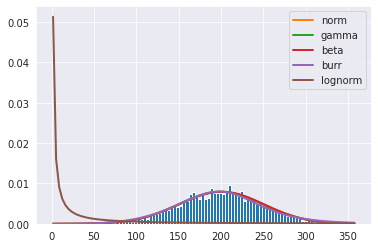

In [401]:
# total eve minutes is also a normal distribution
f = Fitter(df_train.total_eve_minutes,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.000591,1451.826511,-67082.205888,inf
beta,0.000591,1444.889790,-67064.779861,inf
gamma,0.000592,1461.625218,-67071.095276,inf
lognorm,0.000593,1479.724191,-67059.028414,inf
burr,0.000791,1446.328059,-65829.363628,inf


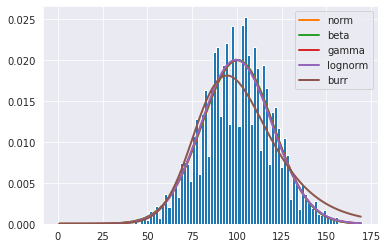

In [402]:
f = Fitter(df_train.total_eve_calls,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.002679,920.940857,-60660.754072,inf
gamma,0.002683,926.803483,-60646.200562,inf
lognorm,0.002684,928.198399,-60644.595278,inf
beta,0.002698,920.708466,-60613.086074,inf
burr,0.003997,877.570404,-58943.533626,inf


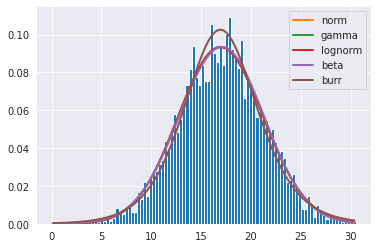

In [403]:
f = Fitter(df_train.total_eve_charge,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.000019,1484.814700,-81594.793648,inf
gamma,0.000019,1487.060651,-81585.652811,inf
beta,0.000019,1489.206293,-81575.851509,inf
burr,0.000044,1544.062100,-78112.715492,inf
lognorm,0.003676,1615.392031,-59308.037701,inf


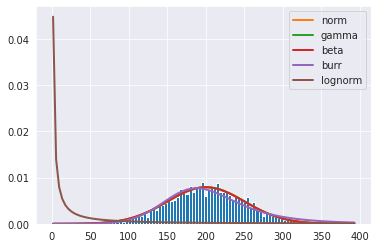

In [404]:
f = Fitter(df_train.total_night_minutes,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.000547,1457.763233,-67413.941788,inf
gamma,0.000547,1461.552840,-67403.231251,inf
beta,0.000547,1463.818907,-67394.513145,inf
lognorm,0.000550,1477.689317,-67382.913863,inf
burr,0.000602,1380.262455,-66991.918151,inf


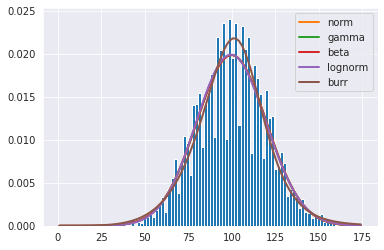

In [405]:
f = Fitter(df_train.total_night_calls,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
norm,0.010007,864.317352,-55059.504174,inf
gamma,0.010010,866.561977,-55049.868184,inf
beta,0.010014,868.697982,-55039.779026,inf
lognorm,0.010133,868.338165,-54997.953080,inf
burr,0.014657,825.252937,-53421.088424,inf


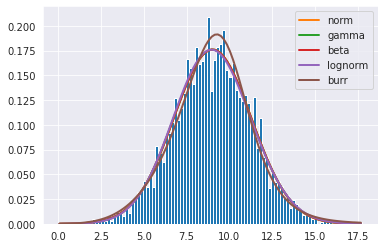

In [406]:
f = Fitter(df_train.total_night_charge,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
beta,0.103740,838.773204,-45103.867475,inf
burr,0.103808,790.884128,-45101.087689,inf
norm,0.104751,829.288717,-45079.384937,inf
lognorm,0.104890,833.958925,-45065.401982,inf
gamma,0.106874,827.496113,-44985.740283,inf


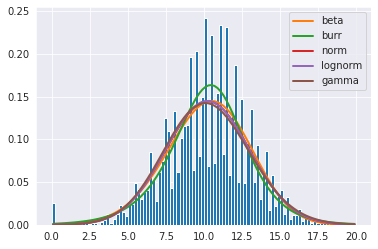

In [407]:
f = Fitter(df_train.total_intl_minutes,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
burr,2.723691,923.327760,-31215.498051,inf
lognorm,2.724298,938.551531,-31222.905293,inf
gamma,2.726712,993.919354,-31219.141440,inf
beta,2.728955,1101.789087,-31207.292378,inf
norm,2.769918,1429.753108,-31160.680955,inf


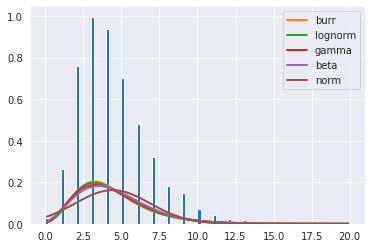

In [408]:
f = Fitter(df_train.total_intl_calls,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
beta,1.540893,576.164331,-33636.407942,inf
norm,1.555724,567.456122,-33612.406345,inf
lognorm,1.557882,570.331418,-33598.159625,inf
gamma,1.583015,567.203259,-33530.142870,inf
burr,2.215095,595.486491,-32093.941945,inf


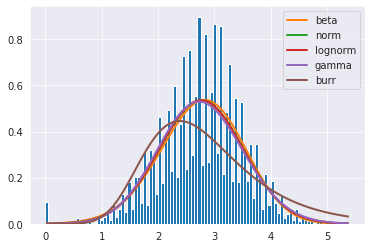

In [409]:
f = Fitter(df_train.total_intl_charge,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

,sumsquare_error,aic,bic,kl_div
burr,25.480749,781.160796,-21712.773175,inf
gamma,26.269112,868.543861,-21591.627875,inf
beta,26.602065,812.487726,-21529.744292,inf
lognorm,27.100227,705.122686,-21459.247640,inf
norm,27.209513,1137.532327,-21450.498034,inf


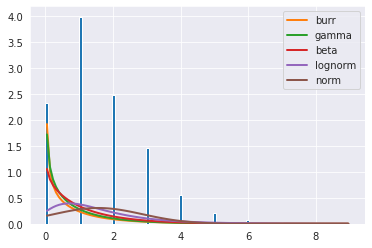

In [410]:
f = Fitter(df_train.number_customer_service_calls,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()

f.summary()

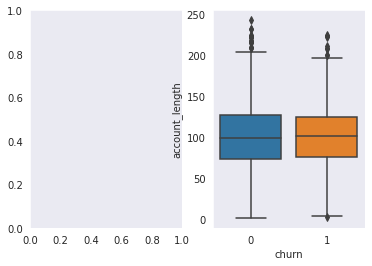

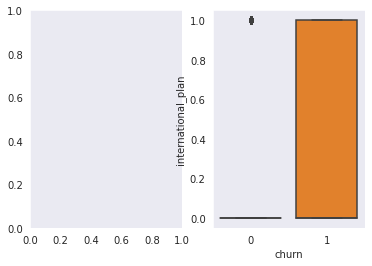

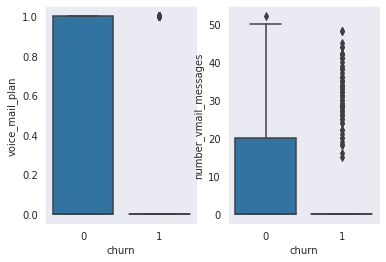

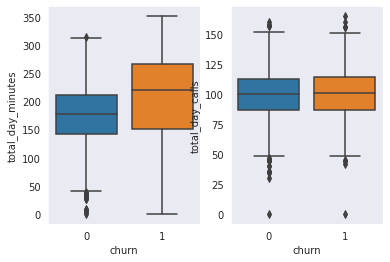

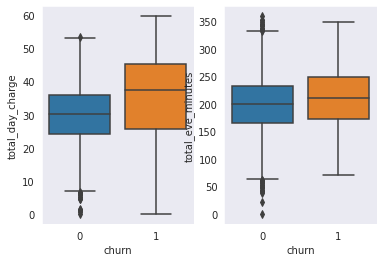

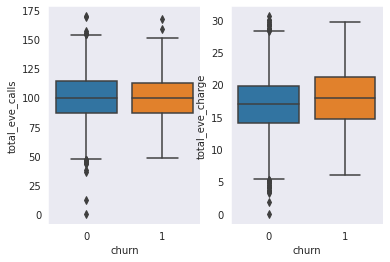

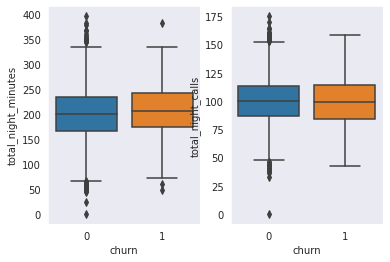

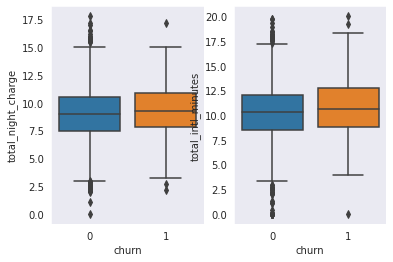

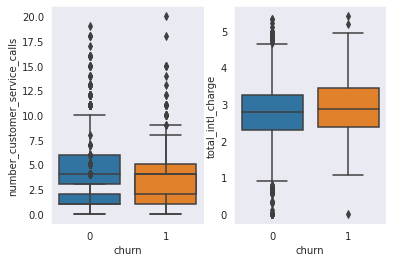

In [411]:
# To organize our plots and keep them in the same figure
# reference - https://seaborn.pydata.org/generated/seaborn.boxplot.html
fig, axs = plt.subplots(ncols=2)
# First box plot of state vs churn
# sns.boxplot(x='churn', y='state', data=df_train, ax=axs[0])
# Second box plot for account length vs churn
sns.boxplot(x='churn', y='account_length', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for area code vs churn
# sns.boxplot(x='churn', y='area_code', data=df_train, ax=axs[0])
# Fourth box plot for international plan vs churn
sns.boxplot(x='churn', y='international_plan', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for voice_mail_plan vs churn
sns.boxplot(x='churn', y='voice_mail_plan', data=df_train, ax=axs[0])
# Fourth box plot for number_vmail_messages vs churn
sns.boxplot(x='churn', y='number_vmail_messages', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_day_messages vs churn
sns.boxplot(x='churn', y='total_day_minutes', data=df_train, ax=axs[0])
# Fourth box plot for total_day_calls vs churn
sns.boxplot(x='churn', y='total_day_calls', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_day_charge vs churn
sns.boxplot(x='churn', y='total_day_charge', data=df_train, ax=axs[0])
# Fourth box plot for total_eve_minutes vs churn
sns.boxplot(x='churn', y='total_eve_minutes', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_eve_calls vs churn
sns.boxplot(x='churn', y='total_eve_calls', data=df_train, ax=axs[0])
# Fourth box plot for total_eve_charge vs churn
sns.boxplot(x='churn', y='total_eve_charge', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_night_minutes vs churn
sns.boxplot(x='churn', y='total_night_minutes', data=df_train, ax=axs[0])
# Fourth box plot for total_night_calls vs churn
sns.boxplot(x='churn', y='total_night_calls', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_night_charge vs churn
sns.boxplot(x='churn', y='total_night_charge', data=df_train, ax=axs[0])
# Fourth box plot for total_intl_minutes vs churn
sns.boxplot(x='churn', y='total_intl_minutes', data=df_train, ax=axs[1])

fig, axs = plt.subplots(ncols=2)
# Third box plot for total_intl_calls vs churn
sns.boxplot(x='churn', y='total_intl_calls', data=df_train, ax=axs[0])
# Fourth box plot for total_intl_charge vs churn
sns.boxplot(x='churn', y='total_intl_charge', data=df_train, ax=axs[1])

# fig, axs = plt.subplots(ncols=1)
# Third box plot for number_customer_service_calls vs churn
sns.boxplot(x='churn', y='number_customer_service_calls', data=df_train, ax=axs[0])


# this prevents plots from overlapping
# plt.tight_layout()
plt.subplots_adjust(hspace = 1)

### Dimentionality Reduction Techniques



1.   Percent missing values
2.   Amount of Variation
3.   Pairwise Correlation
4.   Multicolinearity
5.   Principal Component Analysis(PCA)
6.   Cluster Analysis
7.   Correlation (with target)
8.   Forward Selection
9.   Backward Elimination(RFE)
10.  Stepwise Selection
11.  LASSO
12.  Tree-based selection





In [412]:
# Check % of missing values
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'column_name': df_train.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
state,state,0.0
account_length,account_length,0.0
international_plan,international_plan,0.0
voice_mail_plan,voice_mail_plan,0.0
number_vmail_messages,number_vmail_messages,0.0
total_day_minutes,total_day_minutes,0.0
total_day_calls,total_day_calls,0.0
total_day_charge,total_day_charge,0.0
total_eve_minutes,total_eve_minutes,0.0
total_eve_calls,total_eve_calls,0.0


In [413]:
# Check amount of variation
df_train.var()


state                             218.124818
account_length                   1575.963008
international_plan                  0.084515
voice_mail_plan                     0.193233
number_vmail_messages             180.630433
total_day_minutes                2917.336473
total_day_calls                   394.054948
total_day_charge                   84.310888
total_eve_minutes                2525.014078
total_eve_calls                   396.352000
total_eve_charge                   18.243252
total_night_minutes              2535.479804
total_night_calls                 403.737482
total_night_charge                  5.134402
total_intl_minutes                  7.618162
total_intl_calls                    6.066709
total_intl_charge                   0.555329
number_customer_service_calls       1.719858
churn                               0.120936
area_code_area_code_408             0.190279
area_code_area_code_415             0.250043
area_code_area_code_510             0.186777
dtype: flo

In [414]:
# y = df_train['churn']
# X_train = df_train.drop(columns=['churn', 'state', 'area_code', 'international_plan', 'voice_mail_plan'])
# X_train.head()


corr_matrix = df_train.corr()
corr_matrix



,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510
state,1.000000,0.008818,0.003822,-0.034752,-0.030857,0.014263,-0.009890,0.014262,0.001603,-0.009116,0.001603,0.004827,-0.006597,0.004815,-0.010260,0.007469,-0.010284,-0.020421,0.007181,-0.012611,-0.007406,0.021298
account_length,0.008818,1.000000,0.027050,0.001663,-0.006626,-0.001612,0.023002,-0.001613,-0.010326,0.005535,-0.010322,-0.009916,-0.001846,-0.009942,0.004539,0.013690,0.004494,0.001002,0.019378,0.019400,-0.000438,-0.019074
international_plan,0.003822,0.027050,1.000000,0.000714,0.004808,0.040059,0.009776,0.040061,0.023484,-0.003004,0.023479,-0.020694,0.007153,-0.020694,0.023815,0.006956,0.023799,-0.008881,0.259053,-0.017055,-0.008768,0.027359
voice_mail_plan,-0.034752,0.001663,0.000714,1.000000,0.954014,-0.000653,-0.010004,-0.000658,0.011982,0.000263,0.011989,0.017884,0.007872,0.017875,0.008098,-0.005674,0.008129,-0.021504,-0.114643,-0.006319,0.013328,-0.009043
number_vmail_messages,-0.030857,-0.006626,0.004808,0.954014,1.000000,0.002000,-0.006920,0.001994,0.010725,0.003593,0.010736,0.018308,0.001977,0.018300,0.005220,0.006585,0.005249,-0.015303,-0.100347,-0.003496,0.009604,-0.007583
total_day_minutes,0.014263,-0.001612,0.040059,-0.000653,0.002000,1.000000,0.000747,1.000000,-0.013248,0.005986,-0.013258,0.010049,-0.004812,0.010036,-0.021369,0.003859,-0.021291,-0.002925,0.215272,-0.020158,0.026162,-0.009924
total_day_calls,-0.009890,0.023002,0.009776,-0.010004,-0.006920,0.000747,1.000000,0.000751,0.008661,0.003739,0.008663,0.002206,-0.004815,0.002200,0.008834,0.009377,0.008909,-0.015845,0.011640,-0.021970,0.051199,-0.037065
total_day_charge,0.014262,-0.001613,0.040061,-0.000658,0.001994,1.000000,0.000751,1.000000,-0.013247,0.005985,-0.013257,0.010053,-0.004816,0.010040,-0.021374,0.003853,-0.021296,-0.002932,0.215263,-0.020159,0.026167,-0.009928
total_eve_minutes,0.001603,-0.010326,0.023484,0.011982,0.010725,-0.013248,0.008661,-0.013247,1.000000,0.003101,1.000000,-0.014018,0.011973,-0.014031,-0.003509,0.012239,-0.003460,-0.010063,0.078855,0.012359,-0.021216,0.012073
total_eve_calls,-0.009116,0.005535,-0.003004,0.000263,0.003593,0.005986,0.003739,0.005985,0.003101,1.000000,0.003120,0.008425,-0.011929,0.008441,-0.013096,0.004949,-0.013145,0.006956,-0.006817,0.015348,-0.006856,-0.007559


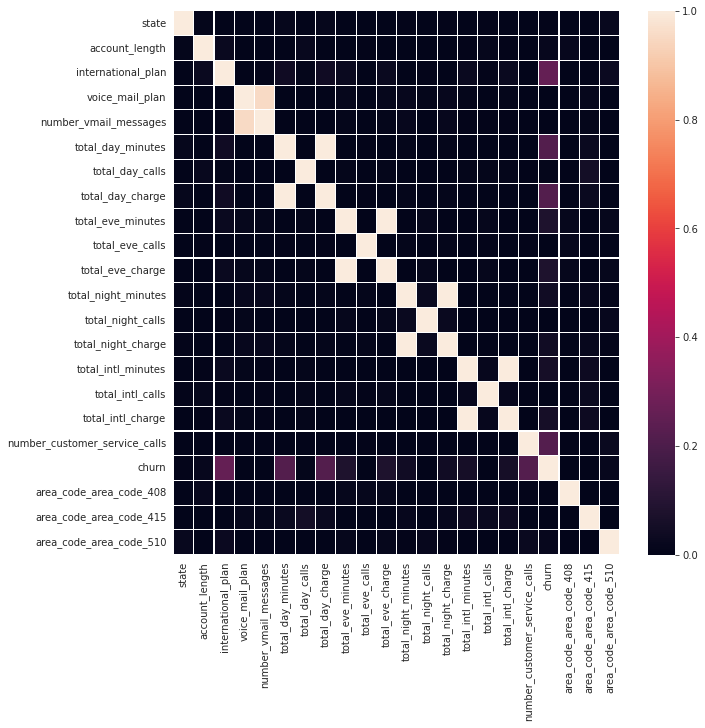

In [415]:

sns.color_palette("mako", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(df_train.corr(), linewidths=0.1, vmin=0, vmax=1)


In [416]:
x = df_train.drop('churn',axis=1).values
y = train.churn.values
id_submission = df_test.id
df_test = df_test.drop('id', axis=1)
# spliting the data into test and train
x_train, x_test , y_train, y_test = train_test_split(x, y , test_size=0.3, random_state=0)

In [417]:
x_train

array([[  8.,  87.,   0., ...,   0.,   1.,   0.],
       [ 33., 113.,   0., ...,   0.,   0.,   1.],
       [ 43.,  75.,   0., ...,   0.,   1.,   0.],
       ...,
       [ 22., 126.,   1., ...,   0.,   1.,   0.],
       [ 22.,  82.,   0., ...,   0.,   1.,   0.],
       [ 27., 110.,   0., ...,   1.,   0.,   0.]])

In [418]:
print('Before upsampling count of label 0 {}'.format(sum(y_train==0)))
print('Before upsampling count of label 1 {}'.format(sum(y_train==1)))
# Minority Over Sampling Technique
sm = SMOTE(sampling_strategy = 1, random_state=1)   
x_train_s, y_train_s = sm.fit_resample(x_train, y_train.ravel())
                                         
print('After upsampling count of label 0 {}'.format(sum(y_train_s==0)))
print('After upsampling count of label 1 {}'.format(sum(y_train_s==1)))

Before upsampling count of label 0 0
Before upsampling count of label 1 0
After upsampling count of label 0 0
After upsampling count of label 1 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [419]:
# creating the object of minmax scaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
test = scaler.transform(df_test)

In [420]:
svc = SVC(kernel='rbf', decision_function_shape='ovr')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('\n')
clf_svc = confusion_matrix(y_test, y_pred)
print('True Positives : ',clf_svc[0][0])
print('False Negatives : ',clf_svc[0][1])
print('False Positives : ',clf_svc[1][0])
print('True Negatives : ',clf_svc[1][1])
print('\n')
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.8901960784313725
Classification report: 
              precision    recall  f1-score   support

          no       0.89      0.99      0.94      1102
         yes       0.84      0.24      0.37       173

    accuracy                           0.89      1275
   macro avg       0.86      0.61      0.65      1275
weighted avg       0.88      0.89      0.86      1275

Confusion Matrix
[[1094    8]
 [ 132   41]]


True Positives :  1094
False Negatives :  8
False Positives :  132
True Negatives :  41


Cohen kappa score: 
0.32918946545607597


In [421]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('\n')
clf_rfc = confusion_matrix(y_test, y_pred)
print('True Positives : ',clf_rfc[0][0])
print('False Negatives : ',clf_rfc[0][1])
print('False Positives : ',clf_rfc[1][0])
print('True Negatives : ',clf_rfc[1][1])
print('\n')
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.96
Classification report: 
              precision    recall  f1-score   support

          no       0.96      0.99      0.98      1102
         yes       0.96      0.74      0.83       173

    accuracy                           0.96      1275
   macro avg       0.96      0.87      0.91      1275
weighted avg       0.96      0.96      0.96      1275

Confusion Matrix
[[1096    6]
 [  45  128]]


True Positives :  1096
False Negatives :  6
False Positives :  45
True Negatives :  128


Cohen kappa score: 
0.8115550583809819


In [422]:
clf = XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.7, 
                        subsample=0.8, nthread=10, learning_rate=0.01)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('\n')
clf_cnf = confusion_matrix(y_test, y_pred)
print('True Positives : ',clf_cnf[0][0])
print('False Negatives : ',clf_cnf[0][1])
print('False Positives : ',clf_cnf[1][0])
print('True Negatives : ',clf_cnf[1][1])
print('\n')
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.9639215686274509
Classification report: 
              precision    recall  f1-score   support

          no       0.96      1.00      0.98      1102
         yes       0.99      0.74      0.85       173

    accuracy                           0.96      1275
   macro avg       0.98      0.87      0.91      1275
weighted avg       0.97      0.96      0.96      1275

Confusion Matrix
[[1101    1]
 [  45  128]]


True Positives :  1101
False Negatives :  1
False Positives :  45
True Negatives :  128


Cohen kappa score: 
0.8277108009024252


Submission

In [423]:
y_pred_sub = clf.predict(test)

In [424]:
submit = pd.DataFrame({'id':id_submission, 'churn':y_pred_sub})
submit.head()

,id,churn
0,1,no
1,2,no
2,3,yes
3,4,no
4,5,no


In [425]:
# replace 0 to no and 1 to yes
# submit.churn.replace([0,1],['no','yes'], inplace=True)

In [427]:
submit.to_csv('churn_submit.csv',index=False)

### Licensing & Citation

`Copyright 2021 Kshitij Zutshi`
```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```